pandas.read_csv(filepath_or_buffer, sep=', ', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal='.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=False, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=False, compact_ints=False, use_unsigned=False, low_memory=True, buffer_lines=None, memory_map=False, float_precision=None)

In [59]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

def general_explore_file(filepath, show = False):
    df = pd.read_csv(filepath)
    if show:
        explore_df(df)
    return df

def get_prep_data(filepath, parse_dt = ['Opened'], fix_index = 'CaseID'):
    df = pd.read_csv(filepath, parse_dates =parse_dt, infer_datetime_format=True)
    if fix_index:
        df.set_index(fix_index, inplace = True)
    return df
    
def read_csv_chunks_into_df(file_path, chunk_size, parse_date=False):    
    if parse_date:
        chunks = pd.read_csv(file_path, parse_dates= ['Opened','Closed','Updated'], infer_datetime_format=True, chunksize = chunk_size )
    else:
        chunks = pd.read_csv(file_path, chunksize = chunk_size )
    df = pd.concat(chunks) 
    return df

def explore_df(df):
    print '*********** Shape of df **************'
    print df.shape
    features = df.columns.values    
    print '********** Number of features ***************'
    print len(features) 
    print '********** Features ***************'
    print features
    print '******* Head of df ******************'
    print df.head()
    print '******* Info of df ******************'
    print df.info()
    print '******** Description of df *****************'
    print df.describe()
    return
    
def get_unique(df):
    features = df.columns.values
    print '********* Number of unique values **********'
    for feature in features:
        print feature,' ', len(df[feature].unique())
    return 

def get_missing(df):
    print '********* Number of missing values **********'
    df2 = df.isnull()
    features = df.columns.values
    for feature in features:
        temp = df[df2[feature]]
        print feature,' ', len(temp)

def drop_na_row(df,feature):
    df = df.ix[df[feature].notnull(), :]
    return df

def get_value_counts(df, feature_list):
    for feature in feature_list:
        print '************ '+feature+' value counts ***********'
        print df[feature].value_counts(dropna = False)
    return

def parsedate(df, columns, time_format):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format = time_format)
    return df

def days_to_minutes(dt):
    return  dt.total_seconds()//60#(td.seconds//60)%60

def days_to_hours(dt):
    hours = dt.total_seconds()/3600#(td.seconds//60)%60
    return np.round(hours,1)

def get_sorted_category_value(df, category):
    ''' returns sorted categorical values based on the mean process_hours '''
    dfm = df.groupby(category).mean()
    dfm = dfm.sort_values('Process_hours')
    return dfm.index

def category_to_numer_dict(df, category, values):
    '''
    Change a categorical column to numeric and save the categorical values in a dictionary for later reference
    values is sorted list of categorical values
    '''
    dict = defaultdict(str)
    for i,value in enumerate(values):
        dict[i] = value # store the categorical values in a dictionary for later reference
        df.ix[df[category]==value, category] = i
    return dict

def category_to_numer_basic(df, category):
    '''Change a categorical column to numeric and save the categorical values in a dictionary for later reference (basic version)'''
    values = df[category].unique()
    for i,value in enumerator(values):
        df.ix[df[category]==value, category] = i
    return df

'''######## this can be a short lambda expression########'''
def get_str_list(string):
    '''convert to a list of string'''
    return str(string).split()

'''######## this can be a short lambda expression########'''
def check_dup(str_list):
    '''check if word 'Duplicate' is in the string list'''
    return 'Duplicate' in str_list
    
def check_word_in_col(df, column, word):
    df1 = df.copy()
    get_str_list = lambda x: str(x).split()
    check_dup = lambda x: word in x

    df1[column+'1'] = df1[column].apply(get_str_list) # turn df1[column] into a list of strings
    cond = df1[column+'1'].apply(check_dup) # check if df1[column+'1'] contains the word
    df_dup = df1[cond]
    return df_dup


procedure:
1. Read data from SF311.csv (2092917 cases).
    Parse dates of 'Opened', Closed','Updated' to pd.datetime64.
    Sort the data by CaseID, which is the same order by case open time. 
    Remove the open case (with no closed time/status==open, 99549 cases), these cases were stored in SF311_still_open_raw.csv
    There were 1993368 cases that were closed.
    calculate the process time as 'Process_days' by (Closed' - 'Opened'), 'Process_days' is time_delta object
    creat 'Process_hours' (data type of float) by converting 'Process_days' to hours
    Remove the cases with process time <= 0hr(23575 cases)
    The rest valide 196973 cases were stored in SF311_valid_raw.csv 
    For the valid cases:
    Remove columns: 'Closed','Updated','Status', 'Media URL', becuase these columns offer no helpful information
    Save these cases to SF311_valid_fewer_features.csv (this convert 'Process_days' to string. 
    Will not use 'Process_days' to do calculation, just for easy assessment of time)

In [ ]:
'''
###################################################################
From here: can be skipped because the valid cases have been stored in csv file
###################################################################
'''
filepath = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/SF311.csv'
df = general_explore_file(filepath)
df = df.sort_values('CaseID')
df.set_index('CaseID', inplace = True)
# print df.shape
# df.head()
''' parse dates'''
dt_list = ['Opened','Closed','Updated'] # list datetime columns
time_format = '%m/%d/%Y %I:%M:%S %p'
dft = parsedate(df, dt_list, time_format) # parse ['Opened','Closed','Updated'] to timedate 
# dft.info()

In [ ]:
'''remove and save the cases that are not closed'''
dft_still_open = dft[dft['Closed'].isnull()] # cases that not closed
dft_still_open_csv_path = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/SF311_still_open_raw.csv'
dft_still_open.to_csv(dft_still_open_csv_path) # dft_still_open.csv contains cases that not closed
print 'Cases that are not closed: ', len(dft_still_open)

'''calculate the process time and remove cases with process time <= 0 hours and save the valid cases '''
condition = dft['Closed'].notnull()
dft_closed = dft[condition] # cases that are closed 
dft_closed['Process_days'] = dft_closed['Closed'] - dft_closed['Opened']
dft_closed['Process_hours'] = dft_closed['Process_days'].apply(days_to_hours)

dft_wrong_dates = dft_closed[dft_closed['Process_hours'] <= 0]
dft_valid = dft_closed[dft_closed['Process_hours'] > 0]
print 'Cases with process time <= 0: ', len(dft_wrong_dates)
print ' Valid cases: ', len(dft_valid)

dft_wrong_dates_csv_path = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/SF311_wrong_dates_raw.csv'
dft_wrong_dates.to_csv(dft_wrong_dates_csv_path) # dft_wrong_dates_raaw.csv contains cases that have wrong dates: closed before opened'''re

dft_valid_csv_path = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/SF311_valid_raw.csv'
dft_valid.to_csv(dft_valid_csv_path)

In [ ]:
'''remove unnecessary columns and save the cases to csv file'''
drop_col = ['Closed','Updated','Status', 'Media URL']
dft_valid_fewer_features = dft_valid.drop(drop_col, axis =1)

dft_valid_fewer_features_csv_path = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/SF311_valid_fewer_features.csv'
dft_valid_fewer_features.to_csv(dft_valid_fewer_features_csv_path)
# print dft_valid_fewer_features.info()
# dft_valid_fewer_features.head()

In [ ]:
''' verify the new csv files'''
ndf = pd.read_csv(dft_still_open_csv_path)
print ndf.shape
cdf = pd.read_csv(dft_valid_csv_path)
print cdf.shape

'''
###################################################################
To here: can be skipped because the valid cases have been stored in csv file
###################################################################
'''

In [21]:
cfdf = get_prep_data(dft_valid_fewer_features_csv_path)
# print cfdf.shape
# print cfdf.info()
# cfdf.head(2)
'''Convert the column 'Category' to numerical'''
cate_val = get_sorted_category_value(cfdf,'Category') 
req_type_val = get_sorted_category_value(cfdf,'Request Type')

dft_cat_dict = category_to_numer_dict(cfdf, 'Category',cate_val)
dft_req_type_dict = category_to_numer_dict(cfdf, 'Request Type', req_type_val)


In [29]:
dfm = cfdf.groupby('Category')['Process_hours'].describe()
print dft_cat_dict.items()
dfm

[(0, 'Construction Zone Permits'), (1, 'Abandoned Vehicle'), (2, 'MUNI Feedback'), (3, 'Street and Sidewalk Cleaning'), (4, 'Noise Report'), (5, 'Litter Receptacles'), (6, 'Illegal Postings'), (7, 'Graffiti Public Property'), (8, 'Residential Building Request'), (9, 'DPW Volunteer Programs'), (10, 'Streetlights'), (11, 'Sewer Issues'), (12, 'Graffiti Private Property'), (13, 'Street Defects'), (14, 'Catch Basin Maintenance'), (15, 'Blocked Street or SideWalk'), (16, 'Temporary Sign Request'), (17, 'General Requests'), (18, 'Damaged Property'), (19, '311 External Request'), (20, 'Sign Repair'), (21, 'Rec and Park Requests'), (22, 'Interdepartmental Request'), (23, 'Tree Maintenance'), (24, 'Color Curb'), (25, 'SFHA Requests'), (26, 'Sidewalk or Curb'), (27, 'Unpermitted Cab Complaint')]


Category       
0         count      2635.000000
          mean         70.362201
          std         277.083900
          min           0.100000
          25%           4.500000
          50%          17.800000
          75%          44.100000
          max        2195.900000
1         count    145094.000000
          mean        122.818032
          std         134.725079
          min           0.100000
          25%          64.000000
          50%         117.200000
          75%         162.800000
          max       26279.600000
2         count     53594.000000
          mean        134.032879
          std         433.812814
          min           0.100000
          25%          48.800000
          50%          96.900000
          75%         164.600000
          max       55398.600000
3         count    729100.000000
          mean        138.903609
          std        1087.317912
          min           0.100000
          25%           3.000000
          50%          17.3

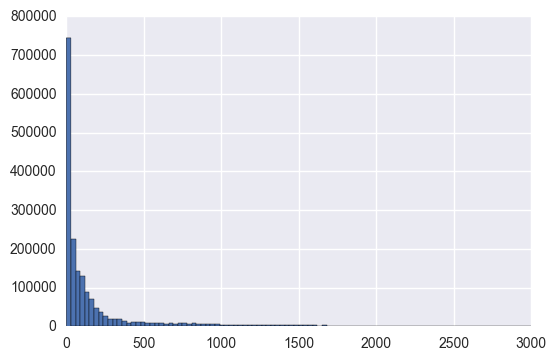

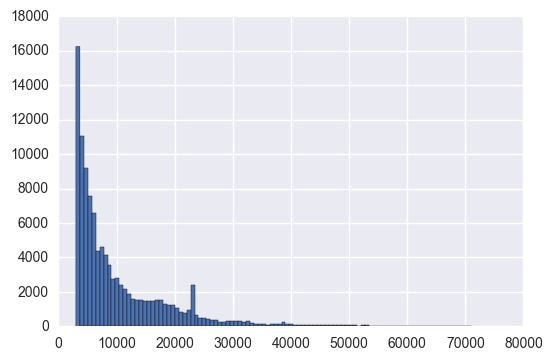

1860501
109292


In [13]:
'''plot the histogram of Category and Request type'''
# cfdf.Process_hours.hist(bins =100)
# plt.show()
'''Distribution of process time is very skewed'''

cfdf_norm = cfdf[cfdf.Process_hours < 3000]
cfdf_extreme = cfdf[cfdf.Process_hours >= 3000]
cfdf_norm.Process_hours.hist(bins =100)
plt.show()
cfdf_extreme.Process_hours.hist(bins =100)
plt.show()

print len(cfdf_norm)
print len(cfdf_extreme)

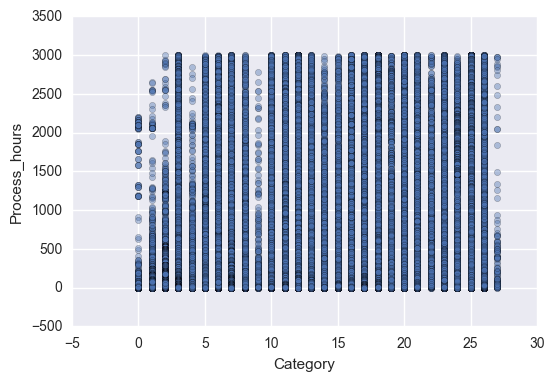

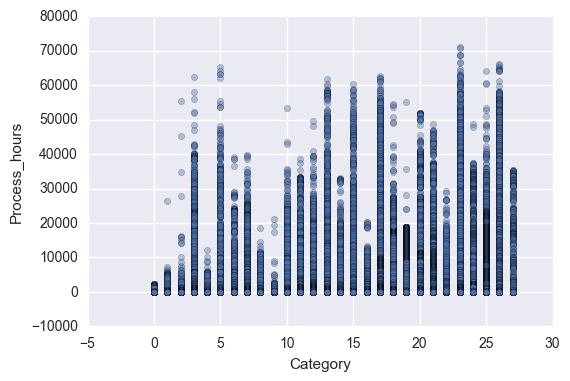

In [16]:
cfdf_norm.plot(kind = 'scatter', x='Category', y='Process_hours', alpha = 0.4)
plt.show()
cfdf.plot(kind = 'scatter', x='Category', y='Process_hours', alpha = 0.4)
plt.show()

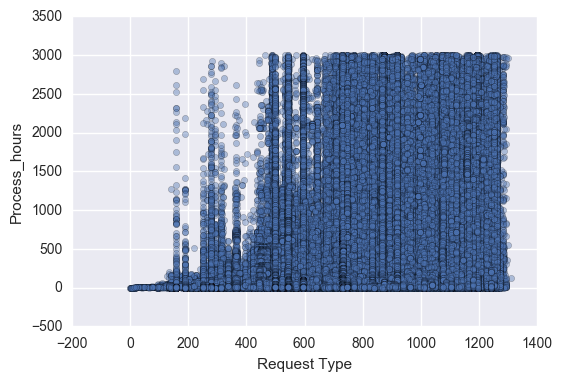

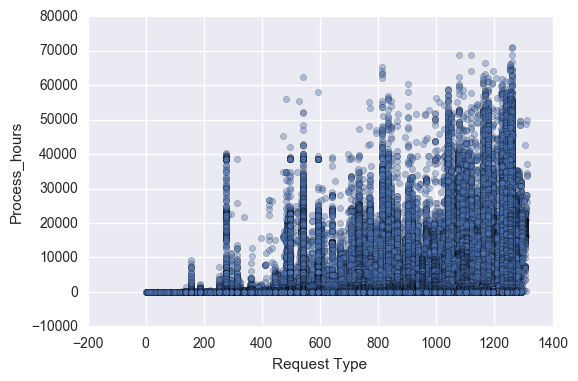

In [31]:
cfdf_norm.plot(kind = 'scatter', x='Request Type', y='Process_hours', alpha = 0.4)
plt.show()
cfdf.plot(kind = 'scatter', x='Request Type', y='Process_hours', alpha = 0.4)
plt.show()

CaseID   2092917
Opened   2029272
Closed   1485294
Updated   1570351
Status   2
Status Notes   348637
Responsible Agency   409
Category   28
Request Type   1419
Request Details   133593
Address   199413
Supervisor District   14
Neighborhood   126
Point   217287
Source   9
Media URL   377721

In [ ]:
cfdf1 = get_prep_data(dft_valid_fewer_features_csv_path)

In [45]:
df_sh = cfdf1[cfdf1['Process_hours'] < 0.5].sort_values('Process_hours')
print len(df_sh)
print len(cfdf1)
df_sh.head(20)

34276
1969793


,Opened,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Point,Source,Process_days,Process_hours
CaseID,,,,,,,,,,,,,
2335621,2013-05-07 09:56:27,Case Resolved - Meter repaired,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,Intersection of 5TH ST and BLUXOME ST,6.0,South of Market,"(37.7759411609503, -122.39796943063)",Voice In,0 days 00:06:27.000000000,0.1
5420600,2015-12-31 14:54:22,Case Resolved - COMPLAINT WAS GIVEN TO OFFICER...,SFMTA - Parking Enforcement - G,General Requests,mta - parking_enforcement - request_for_service,mta - parking_enforcement - request_for_service,Intersection of ANZA ST and 44TH AVE,1.0,Sutro Heights,"(37.7772385424156, -122.504952281333)",Other Department,0 days 00:04:53.000000000,0.1
4398367,2015-01-16 07:05:02,Case Transferred -,PUC - Water - G,Sewer Issues,Water_leak,Other,"170 BEAUMONT AVE, SAN FRANCISCO, CA, 94118",1.0,Lone Mountain,"(37.778540196152, -122.454364928978)",Voice In,0 days 00:06:12.000000000,0.1
4398310,2015-01-16 05:57:05,Case is a Duplicate -,PUC - Water - G,Sewer Issues,Water_leak,Other,"174 BEAUMONT AVE, SAN FRANCISCO, CA, 94118",1.0,Lone Mountain,"(37.778360833192, -122.454328426685)",Voice In,0 days 00:03:19.000000000,0.1
4398291,2015-01-16 05:30:07,Case is a Duplicate -,PUC - Water - G,Sewer Issues,Water_leak,Other,"174 BEAUMONT AVE, SAN FRANCISCO, CA, 94118",1.0,Lone Mountain,"(37.778360833192, -122.454328426685)",Voice In,0 days 00:05:33.000000000,0.1
6136978,2016-07-30 00:17:23,Case is a Duplicate -,DPW Ops Queue,Graffiti Private Property,Not_Offensive Graffiti on Private Property,Building_commercial - Not_Offensive,"761 JACKSON ST, SAN FRANCISCO, CA, 94133",3.0,Chinatown,"(37.795721698012, -122.40772841031)",Voice In,0 days 00:08:08.000000000,0.1
4398285,2015-01-16 05:13:00,Case Resolved - GATEMAN DISPATCHED.,PUC - Water - G,Sewer Issues,Water_leak,Water_main,"174 BEAUMONT AVE, SAN FRANCISCO, CA, 94118",1.0,Lone Mountain,"(37.778360833192, -122.454328426685)",Voice In,0 days 00:08:21.000000000,0.1
4397319,2015-01-15 16:18:07,Case Transferred - CASE TRANSFERRED TO SFWD PA...,PUC - Water - G,General Requests,puc - water - request_for_service,puc - water - request_for_service,Intersection of BUCHANAN ST and HERMANN ST,8.0,Mint Hill,"(37.7706600782474, -122.426780637819)",Voice In,0 days 00:04:56.000000000,0.1
2822972,2013-09-13 08:32:21,Case Resolved - 9/13/2013 - INSTALLED 15W LAMP,PUC Streetlights Queue,Streetlights,Streetlight - Light_Burnt_Out,Light_Burnt_Out on Metal Pole,Intersection of THE EMBARCADERO and WASHINGTON ST,3.0,Financial District,"(37.7966659226524, -122.395324140616)",Web Self Service,0 days 00:07:45.000000000,0.1


In [61]:
# get_str_list = lambda x: str(x).split()
# check_dup = lambda x: 'Duplicate' in x

# cfdf1['Status_notes'] = cfdf1['Status Notes'].apply(get_str_list) # turn cfdf1['Status_notes'] into a list of strings
# cond = cfdf1['Status_notes'].apply(check_dup) # check if cfdf1['Status_notes'] contains the word 'Duplicate'
# df_dup = cfdf1[cond]

# con = cfdf1['Duplicate' in cfdf1['Status_notes']]
# cfdf1.head()
# con
# df_dup = cfdf1['Duplicate' in cfdf1['Status Notes'].apply(get_str_list)]
# len(df_dup)
df_dup = check_word_in_col(cfdf1, 'Status Notes', 'Duplicate')
print len(df_dup)
df_dup.head(20)

'''There are 34773 duplicated cases, remove these cases'''

34773


'There are 34773 duplicated cases, remove these cases'